# Task A: PneumoniaMNIST

## 1. Import library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
from torch.optim import lr_scheduler

## 2. Feature engineering

In [4]:
# Get the data path
path = os.path.abspath(os.path.join('..', 'Datasets/pneumoniamnist.npz'))
print(path)

def data_process(path):
    # Get the dataset
    data = np.load(path)
    # Find the keys oof the dataset
    print(data.keys())
    # Extracting features and labels
    # Nomalization: dividing all features by 255
    train_X = data['train_images']/255.0
    train_y = data['train_labels']
    val_X = data['val_images']/255.0
    val_y = data['val_labels']
    test_X = data['test_images']/255.0
    test_y = data['test_labels']
    return train_X, train_y, val_X, val_y, test_X, test_y

# Determine whether to save the image plotted (These images are used to write report)
# It should be false when you run the program
save_image = True

# set the random seed to 42
torch.manual_seed(42)
train_X, train_y, val_X, val_y, test_X, test_y = data_process(path)


# create train_loader for training
train_tensor_X = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1)

# One-hot encoder to process y (This is used for CrossEntropyLoss)
encoder = OneHotEncoder(sparse=False)

train_tensor_y = torch.tensor(encoder.fit_transform(train_y))
print(train_tensor_X.shape)
train_loader = DataLoader(TensorDataset(train_tensor_X, train_tensor_y), batch_size = 32, shuffle = True)
print(train_loader)

# create validation_loader for validation
val_tensor_X = torch.tensor(val_X, dtype=torch.float32).unsqueeze(1)
val_tensor_y = torch.tensor(encoder.fit_transform(val_y))
val_loader = DataLoader(TensorDataset(val_tensor_X, val_tensor_y), shuffle = False)

# create test_loader for testing
test_tensor_X = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1)
test_tensor_y = torch.tensor(encoder.fit_transform(test_y))
test_loader = DataLoader(TensorDataset(test_tensor_X, test_tensor_y), shuffle = False)

print(train_X.shape)


c:\Users\xrw\Desktop\UCL\APPLIED MACHINE LEARNING\AMLS_assignment23_24-\Datasets\pneumoniamnist.npz
KeysView(NpzFile 'c:\\Users\\xrw\\Desktop\\UCL\\APPLIED MACHINE LEARNING\\AMLS_assignment23_24-\\Datasets\\pneumoniamnist.npz' with keys: train_images, val_images, test_images, train_labels, val_labels...)
torch.Size([4708, 1, 28, 28])
(4708, 28, 28)


d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 3. Convolutional Neural Network(CNN)

Epoch: 1, train_loss: 259.485
Epoch: 1, Accuracy of the network on the train images: 81.46%
Epoch: 1, Accuracy of the network on the val images: 81.30%
Epoch: 1, val_loss: 177.794
Epoch: 2, train_loss: 137.366
Epoch: 2, Accuracy of the network on the train images: 90.57%
Epoch: 2, Accuracy of the network on the val images: 91.22%
Epoch: 2, val_loss: 104.463
Epoch: 3, train_loss: 103.236
Epoch: 3, Accuracy of the network on the train images: 92.42%
Epoch: 3, Accuracy of the network on the val images: 94.66%
Epoch: 3, val_loss: 83.438
Epoch: 4, train_loss: 92.534
Epoch: 4, Accuracy of the network on the train images: 93.01%
Epoch: 4, Accuracy of the network on the val images: 94.85%
Epoch: 4, val_loss: 71.918
Epoch: 5, train_loss: 85.539
Epoch: 5, Accuracy of the network on the train images: 93.52%
Epoch: 5, Accuracy of the network on the val images: 95.42%
Epoch: 5, val_loss: 64.789
Epoch: 6, train_loss: 81.075
Epoch: 6, Accuracy of the network on the train images: 93.73%
Epoch: 6, Accu

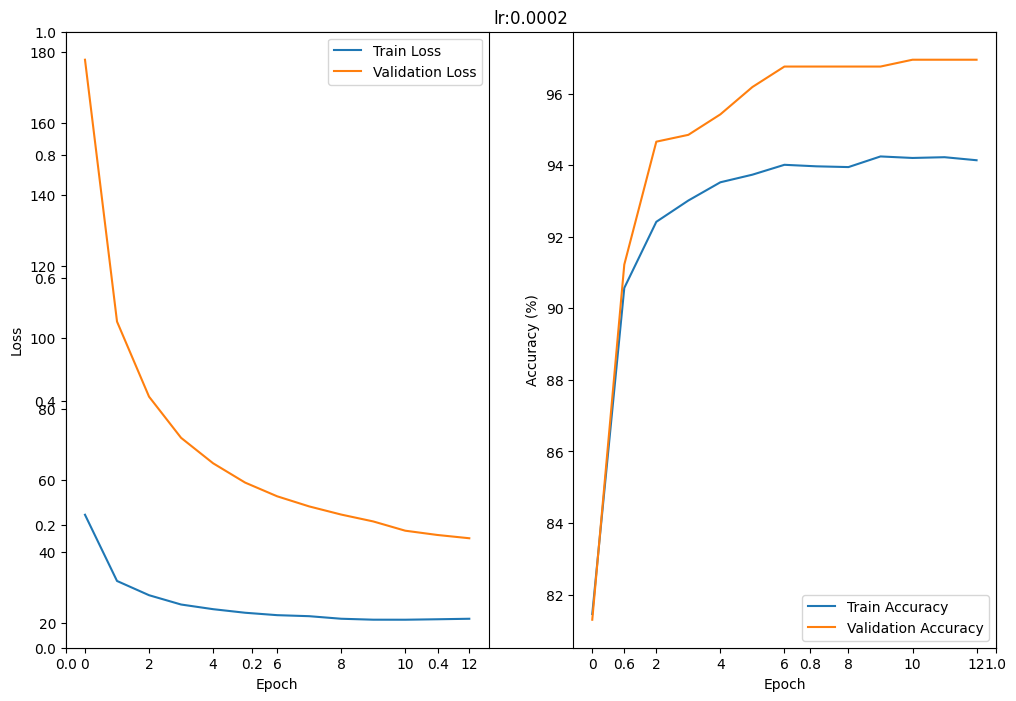

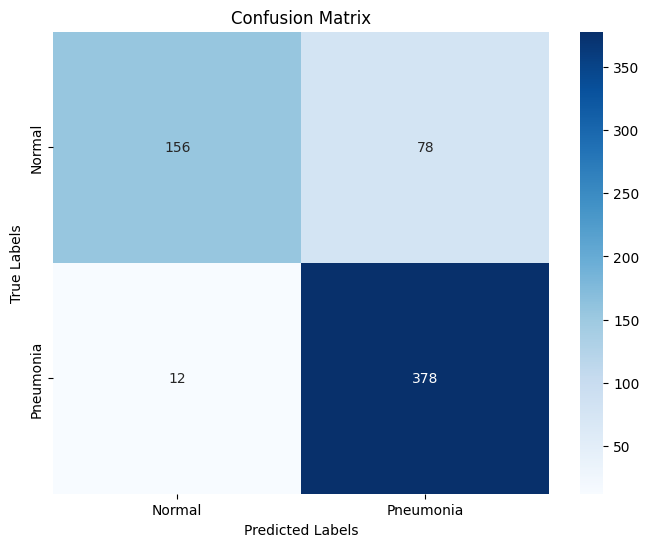

Recall:  0.9692307692307692
Precision:  0.8289473684210527
F1 score:  0.8936170212765957
Epoch: 0, Accuracy of the network on the test images: 85.58%
test accuracy:  85.57692307692308
loss:  tensor(369.1522, dtype=torch.float64)


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 32 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate(model, train_loader, loss_criterion, optimizer, num_epoch, val_loader,scheduler):
    # stop condition
    best_validation_loss = float('inf')
    # how many no_improvement the model can tolerate
    patience = 1
    improvement_threshold = 1
    
    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch_num in range(num_epoch):
        model.train()
        epoch_loss = 0.0
        for i, data in enumerate(val_loader):
            X, y = data
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        print(f'Epoch: {epoch_num + 1}, train_loss: {epoch_loss :.3f}')
        train_accuracy, train_loss = predict(model, train_loader, epoch_num, 'train', loss_criterion)
        val_accuracy, val_loss = predict(model, val_loader, epoch_num, 'val', loss_criterion)
        print(f'Epoch: {epoch_num + 1}, val_loss: {val_loss :.3f}')
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        if  best_validation_loss - val_loss > improvement_threshold:
            best_validation_loss = val_loss
            # Count how many epochs have not improved the model since the best epoch, if it >= patience, the train process will stop early
            early_stopping_counter = 0
            # save the best model
            best_model_state_dict = model.state_dict()
        else:
            early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'Epoch: {epoch_num}, finish')
            break

    model.load_state_dict(best_model_state_dict)
        
    return model, train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list
    
# model : The model after training, 
# loader: The dataset need to be predicted by the model
# epoch_num: The number of the current epoch. 
# type: used to clarify which dataset is being predicted : (train, test, val)
def predict(model, loader, epoch_num, type, loss_criterion):
    model.eval()
    correct = 0
    total = 0
    epoch_loss = 0
    with torch.no_grad():
        for i, samples in enumerate(loader):
            X, y = samples
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            _, predicted = torch.max(outputs.data, axis = 1)
            total += y.size(0)
            # train_loader is encoded for training, while others are not encoded. y is different in these three different datasets([1,0] in train_loader or [0] in others)
            correct += (predicted == np.argmax(y,axis = 1)).sum().item()
            epoch_loss += loss
    # print(correct)
    print(f'Epoch: {epoch_num + 1}, Accuracy of the network on the {type} images: {100 * correct / total:.2f}%')
    return 100 * correct / total, epoch_loss

def get_confusion_matrix(model, X, y, lr):
    output = model(X)
    _, predict_y = torch.max(output.data, axis = 1)
    true_y = np.argmax(y, axis = 1)
    conf_matrix = confusion_matrix(true_y , predict_y)
    # labels
    labels = ['Normal', 'Pneumonia']

    # create images for confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    if(save_image == True):
        plt.savefig(f"C:/Users/xrw/Desktop/UCL/APPLIED MACHINE LEARNING/AMLS_I_assignment_kit/images/confusion{lr}.png")
    plt.show()
    # True Positives
    TP = conf_matrix[1][1]  
    #False Positive
    FP = conf_matrix[0][1]
    # False Negatives
    FN = conf_matrix[1][0]  

    # Compute Recall
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1 score: ', f1_score)
    
    

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, lr, epoch_num):
    plt.figure(figsize=(12, 8))
    plt.title(f'lr:{lr}')
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    if(save_image == True):
        plt.savefig(f"C:/Users/xrw/Desktop/UCL/APPLIED MACHINE LEARNING/AMLS_I_assignment_kit/images/{lr}.png")
    plt.show()
   
    
type = ['train', 'test', 'val']
def CNN_all(lr, lr_decay, epoch_num):
    model = CNN() 
    # Use CrossEntropyLoss to train the model
    loss_criterion = nn.CrossEntropyLoss()
    # l2 regularization
    l2_lambda = 0.001
    
    # optimizer for the CNN
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = l2_lambda)
    
    # learning rate decay
    lr_decay_rate = 0.1
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay_rate)
    
    model, train_accuracy, val_accuracy, train_loss, val_loss = train_and_evaluate(model, train_loader, loss_criterion, optimizer, epoch_num, val_loader, scheduler)
    plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy, lr, epoch_num)
    # After the model is trained, get the confusion matrix and recall
    get_confusion_matrix(model, test_tensor_X, test_tensor_y, lr)
    accuracy, test_loss = predict(model, test_loader, -1, 'test', loss_criterion)
    print('test accuracy: ', accuracy)
    print('loss: ', test_loss)
    # trained_model = train(model,train_loader, loss_criterion, optimizer, 30)
    # predict(trained_model, test_loader)

CNN_all(lr = 0.0002, lr_decay = False, epoch_num = 50)

4. Support Vector Machine (SVM)

In [11]:
flatten_train_X = train_X.reshape(train_X.shape[0], -1)
flatten_test_X = test_X.reshape(test_X.shape[0], -1)
# create SVM model
svm_classifier = SVC(kernel='rbf', C=1.0)

# Train SVM
svm_classifier.fit(flatten_train_X, train_y)

# predict according to SVM
y_pred = svm_classifier.predict(flatten_test_X)

# Compute accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(test_y, y_pred)

# True Positive
TP = conf_matrix[1][1]  
# False Positive
FP = conf_matrix[0][1]
# False Negatives
FN = conf_matrix[1][0]

# Compute Recall
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score: ', f1_score)
    


d:\anaconda\envs\developing\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 85.42%
Recall:  0.9897435897435898
Precision:  0.8160676532769556
F1 score:  0.8945538818076477
